# DOPP Exercise 3: Corruption

In [1]:
import glob
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from joblib import dump, load

In [2]:
pd.set_option('display.max_columns', None)

Corruption, [defined][^1] as the improper and usually unlawful conduct intended to secure a benefit for oneself or another, is still prominent in many countries around the world, especially in the form of political corruption.

[^1]: https://www.britannica.com/topic/corruption-law

## Measuring corruption &ndash; Corruption Perceptions Index (CPI)

One of the most well-known measures of corruption in countries is the [Corruption Perceptions Index (CPI)](https://www.transparency.org/en/cpi/2019/index/nzl), published yearly by Transparency International, which is intended to measure public sector corruption on a scale of 0 (the highest level of perceived corruption) to 100 (the lowest level of perceived corruption).

The CPI score is an aggregate of other scores collected from a number of different sources ([13 in 2019](https://images.transparencycdn.org/images/2019_CPI_methodology.pdf)) which are based on perceptions of the level of corruption in the public sector by business people and country experts.

## Predicting corruption

The goal of this project is to predict a country's level of corruption based on other country characteristics. The CPI score is the target variable, which we'll try to predict using multiple country indicators and indices collected from various sources, such as:
* [UNDP's Human Development Reports data](http://hdr.undp.org/en/data) (e.g. Human Development Index, Education Index, Income Index, etc.)
* [Index of Economic Freedom data](https://www.heritage.org/index/?version=42) (measures such as Government Integrity, Business Freedom, Tax Burden, etc.)
* [Worldwide Governance Indicators data](https://www.doingbusiness.org/en/data) (indicators such as Government Effectiveness, Regulatory Quality, etc.)

Due to the sheer number of available measures, it would be impossible include them all in our models (and in many cases, it wouldn't even make sense). The focus will therefore be on measures related to governance and politics, since we assume that they could have an effect on the CPI. Additionally, we'll consider well-known indicators that encompass a wide range of country characteristics like education, inequality, poverty, etc.

## Data acquisition

The current CPI methodology ensures that scores are comparable year on year only from 2012 onwards, so we'll focus on collecting data for the 8 years between 2012 and 2019.

### CPI data

CPI data for 2012-2019 was obtained using Transparency International's API and stored as a CSV file.

In [3]:
cpi_df = pd.read_csv('data/cpi.csv', index_col=0)
cpi_df.head()

,country,iso3,region,year,score,rank,sources,standardError
0,New Zealand,NZL,AP,2019,87.0,1.0,8.0,2.29
1,New Zealand,NZL,AP,2018,87.0,2.0,8.0,2.44
2,New Zealand,NZL,AP,2017,89.0,1.0,8.0,2.40
3,New Zealand,NZL,AP,2016,90.0,1.0,7.0,2.56
4,New Zealand,NZL,AP,2015,91.0,1.0,7.0,2.32


We'll drop the columns that we're not interested in:

In [4]:
cpi_df.drop(columns=['rank', 'sources', 'standardError'], inplace=True)

Each country should have an entry for each of the 8 years in the considered timespan:

In [5]:
cpi_df.groupby('country')['year'].count().eq(8).all()

True

However, not all countries have a CPI score for every year:

In [6]:
cpi_df[cpi_df['score'].isna()]

,country,iso3,region,year,score
211,Seychelles,SYC,SSA,2016,NaN
228,Bahamas,BHS,AME,2015,NaN
236,Barbados,BRB,AME,2015,NaN
248,Puerto Rico,PRI,AME,2019,NaN
249,Puerto Rico,PRI,AME,2018,NaN
250,Puerto Rico,PRI,AME,2017,NaN
251,Puerto Rico,PRI,AME,2016,NaN
252,Puerto Rico,PRI,AME,2015,NaN
284,Brunei Darussalam,BRN,AP,2015,NaN
285,Brunei Darussalam,BRN,AP,2014,NaN


Since the CPI score is our target variable, no imputation will be performed on the missing values. Instead, we'll drop the countries with incomplete CPI score data.

In [7]:
countries_to_drop = set(cpi_df[cpi_df['score'].isna()]['country'])

cpi_df = cpi_df[~cpi_df['country'].isin(countries_to_drop)]

In [8]:
cpi_countries = set(cpi_df['country'])

print(f'Countries with complete CPI data: {len(cpi_countries)}')

Countries with complete CPI data: 166


### Human Development Reports data

Data for a selection of Human Development Reports (HDR) indicators was collected through the Human Development Report Office Statistical Data API in JSON form.

In [9]:
with open('data/hdr.json') as file:
    hdr_json = json.load(file)

In [10]:
hdr_json.keys()

dict_keys(['indicator_value', 'country_name', 'indicator_name'])

In [11]:
country_map = hdr_json['country_name']
indicator_map = hdr_json['indicator_name']

The collected HDR indicators are:

In [12]:
print('\n'.join(indicator_map.values()))

Share of seats in parliament (% held by women)
Gender Inequality Index (GII)
Income index
Education index
Coefficient of human inequality
Human Development Index (HDI)
Gender Development Index (GDI)
Employment to population ratio (% ages 15 and older)
GDP per capita (2017 PPP $)
Gross national income (GNI) per capita (constant 2017 PPP$)


Since the obtained JSON contains nested fields, it can't be parsed directly into a `DataFrame`. Instead, we'll focus on reading it country by country and concatenating the parts at the end.

In [13]:
country_dfs = []

for code, country in country_map.items():
    country_json = json.dumps(hdr_json['indicator_value'][code])
    
    country_df = pd.read_json(country_json)
    country_df.reset_index(inplace=True)
    
    country_df['iso3'] = [code] * 8
    country_df['country'] = [country] * 8
    
    country_dfs.append(country_df)

hdr_df = pd.concat(country_dfs)

Indicator names were encoded as integers in the JSON and `year` was set to `index`, so we'll rename the columns:

In [14]:
hdr_df.rename(str, axis='columns', inplace=True)
hdr_df.rename(columns=indicator_map, inplace=True)
hdr_df.rename(columns={'index': 'year'}, inplace=True)

In [15]:
hdr_df.head()

,year,Share of seats in parliament (% held by women),Gender Inequality Index (GII),Income index,Education index,Coefficient of human inequality,Human Development Index (HDI),Gender Development Index (GDI),Employment to population ratio (% ages 15 and older),GDP per capita (2017 PPP $),Gross national income (GNI) per capita (constant 2017 PPP$),iso3,country
0,2012,27.635,0.734,0.464,0.390,NaN,0.489,0.618,42.356,2220.482,2164.641,AFG,Afghanistan
1,2013,27.635,0.724,0.469,0.398,30.033,0.496,0.627,42.479,2264.318,2229.907,AFG,Afghanistan
2,2014,27.635,0.714,0.468,0.403,29.967,0.500,0.634,42.672,2249.254,2214.414,AFG,Afghanistan
3,2015,27.445,0.702,0.462,0.405,30.443,0.500,0.639,42.865,2212.751,2128.162,AFG,Afghanistan
4,2016,27.445,0.690,0.462,0.406,28.188,0.502,0.646,43.028,2200.764,2134.866,AFG,Afghanistan


### Index of Economic Freedom data

The Index of Economic Freedom (IEF) data was acquired from the [IEF webpage](https://www.heritage.org/index/explore?view=by-region-country-year&u=637472005587942125) as one CSV file per year. It consists of 12 quantitative and qualitative factors that are intended to measure economic freedom.

In [16]:
ief_paths = glob.glob("./data/ief_*")

ief_df = pd.concat([pd.read_csv(path) for path in ief_paths])

ief_df.rename(columns={'Name': 'country', 'Index Year': 'year'}, inplace=True)
ief_df['country'] = ief_df['country'].apply(str.rstrip) # fix trailing whitespaces

ief_df.head()

,country,year,Overall Score,Property Rights,Judicial Effectiveness,Government Integrity,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Labor Freedom,Monetary Freedom,Trade Freedom,Investment Freedom,Financial Freedom
0,Afghanistan,2016,NaN,NaN,NaN,12.0,91.6,81.2,NaN,56.6,63.2,NaN,NaN,55.0,NaN
1,Albania,2016,65.9,35.0,NaN,33.0,87.8,75.0,NaN,67.6,51.5,81.7,87.6,70.0,70.0
2,Algeria,2016,50.1,25.0,NaN,36.0,81.0,59.4,NaN,62.1,48.2,68.1,60.8,30.0,30.0
3,Angola,2016,48.9,15.0,NaN,19.0,87.8,50.1,NaN,50.3,44.8,72.2,70.2,40.0,40.0
4,Argentina,2016,43.8,15.0,NaN,34.0,66.1,51.3,NaN,56.0,43.9,44.0,67.4,30.0,30.0


Since the Judicial Effectiveness and Fiscal Health measures didn't exist before 2017. and a country's Overall Score is the average of all the other measures, these three columns will be dropped from the data frame.

In [17]:
ief_df.groupby('year').count()

,country,Overall Score,Property Rights,Judicial Effectiveness,Government Integrity,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Labor Freedom,Monetary Freedom,Trade Freedom,Investment Freedom,Financial Freedom
year,,,,,,,,,,,,,,
2012,185,179,179,0,179,179,179,0,179,179,179,179,179,179
2013,185,177,180,0,184,179,180,0,183,182,181,180,182,180
2014,186,178,181,0,185,183,183,0,184,184,183,180,184,181
2015,186,178,181,0,185,181,183,0,184,184,183,181,184,180
2016,186,178,181,0,185,181,182,0,184,184,183,181,183,181
2017,186,180,185,184,185,182,183,185,186,186,183,183,181,181
2018,186,180,185,185,185,181,183,184,184,184,184,183,184,181
2019,186,180,185,185,185,180,183,183,185,184,184,182,184,181


In [18]:
ief_df.drop(['Overall Score', 'Judicial Effectiveness', 'Fiscal Health'], axis=1, inplace=True)

### Worldwide Governance Indicators data

The Worldwide Governance Indicators (WGI) data was downloaded from the [WGI webpage](http://info.worldbank.org/governance/wgi/). It contains aggregate and individual governance indicators for over 200 countries and territories over the period 1996–2019.

Data for each indicator is stored in a separate spreadsheet and contains additional information such as the number of sources used to compute the indicator, the error margin of the score, etc. For the sake of simplicity, we will extract only the actual indicator score per country and year.

In [19]:
wgi_sheets = {
    1: 'voice and accountability',
    2: 'political stability / no violence',
    3: 'government effectiveness',
    4: 'regulatory quality',
    5: 'rule of law'
}

In [20]:
wgi_df = None

for i, name in wgi_sheets.items():
    sheet_df = pd.read_excel('data/wgidataset.xlsx', header=[13, 14],
                             sheet_name=i)
    
    sheet_df.drop(range(1996, 2012), axis=1, level=0, errors='ignore', inplace=True)
    sheet_df.drop(['Country/Territory', 'Lower', 'NumSrc', 'Rank', 'StdErr', 'Upper'],
                  axis=1, level=1, errors='ignore', inplace=True)
    
    sheet_df.columns = sheet_df.columns.droplevel(1)
    sheet_df.rename(columns={'Unnamed: 1_level_0': 'iso3'}, inplace=True)
    
    sheet_df = pd.melt(sheet_df, id_vars=['iso3'], var_name='year', value_name=name)
    
    if wgi_df is not None:
        wgi_df = pd.merge(wgi_df, sheet_df, on=['iso3', 'year'])
        continue
    
    wgi_df = sheet_df

In [21]:
wgi_df['year'] = wgi_df['year'].astype(int)

In [22]:
wgi_df.head()

,iso3,year,voice and accountability,political stability / no violence,government effectiveness,regulatory quality,rule of law
0,ABW,2012,1.284650,1.263882,1.254732,1.408916,1.316215
1,ADO,2012,1.433838,1.290351,1.531356,1.568978,1.407764
2,AFG,2012,-1.267430,-2.418561,-1.360140,-1.193118,-1.643165
3,AGO,2012,-1.076247,-0.389323,-0.989632,-0.969778,-1.269548
4,AIA,2012,1.025672,1.476920,1.531356,1.327829,1.364446


### Combining the data sets

Combining the HDR and WGI data with CPI is easy as they both have ISO 3 country codes which are uniquely defined.

In [23]:
df = pd.merge(cpi_df, hdr_df, on=['iso3', 'year'], how='left', suffixes=(None, '_hdr'))
df.drop(columns='country_hdr', inplace=True)

df = pd.merge(df, wgi_df, on=['iso3', 'year'], how='left')

To add the IEF data to the rest, we'll have to use country names since ISO 3 codes weren't provided.

Some countries are listed under different names, which can be seen by comparing the differences between the respective sets of names:

In [24]:
display(cpi_countries - set(ief_df['country']),
        set(ief_df['country']) - cpi_countries)

{'Congo',
 "Cote d'Ivoire",
 'Democratic Republic of the Congo',
 'Gambia',
 'Guinea Bissau',
 'Korea, North',
 'Korea, South',
 'Kyrgyzstan',
 'Myanmar',
 'Sao Tome and Principe',
 'United States of America'}

{'Barbados',
 'Belize',
 'Brunei Darussalam',
 'Burma',
 "Côte d'Ivoire",
 'Democratic Republic of Congo',
 'Dominica',
 'Equatorial Guinea',
 'Eswatini',
 'Fiji',
 'Guinea-Bissau',
 'Kiribati',
 'Kyrgyz Republic',
 'Liechtenstein',
 'Macau',
 'Maldives',
 'Micronesia',
 'North Korea',
 'Republic of Congo',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Seychelles',
 'Solomon Islands',
 'South Korea',
 'São Tomé and Príncipe',
 'The Bahamas',
 'The Gambia',
 'Tonga',
 'United States',
 'Vanuatu'}

As we'd like to have as many samples as possible, we'll replace the IEF country names with their CPI counterparts by manually constructing a mapping. This ensures that all countries with complete CPI data properly merge with their IEF indicators.

In [25]:
mapping = {
    'Burma': 'Myanmar',
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Guinea-Bissau': 'Guinea Bissau',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'North Korea': 'Korea, North',
    'Republic of Congo': 'Congo',
    'South Korea': 'Korea, South',
    'São Tomé and Príncipe': 'Sao Tome and Principe',
    'The Gambia': 'Gambia',
    'United States': 'United States of America'
}

ief_df['country'] = ief_df['country'].replace(mapping)

assert cpi_countries - set(ief_df['country']) == set()

In [26]:
df = pd.merge(df, ief_df, on=['country', 'year'], how='left')

#### Final data set

The final data set consists of 1328 entries and 30 columns, 25 of which are the actual variables that we'll use for predicting the CPI score (the remaining 5 are `country`, `iso3`, `region`, `year`, and `score`).

In [27]:
df.columns = df.columns.str.lower()

df.head()

,country,iso3,region,year,score,share of seats in parliament (% held by women),gender inequality index (gii),income index,education index,coefficient of human inequality,human development index (hdi),gender development index (gdi),employment to population ratio (% ages 15 and older),gdp per capita (2017 ppp $),gross national income (gni) per capita (constant 2017 ppp$),voice and accountability,political stability / no violence,government effectiveness,regulatory quality,rule of law,property rights,government integrity,tax burden,government spending,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom
0,New Zealand,NZL,AP,2019,87.0,40.833,0.123,0.908,0.926,7.513,0.931,0.964,67.063,42887.518,40798.720,1.569035,1.507665,1.670904,1.880907,1.884739,95.0,96.7,71.0,50.4,91.0,86.7,87.5,92.4,80.0,80.0
1,New Zealand,NZL,AP,2018,87.0,38.333,0.129,0.907,0.923,9.041,0.928,0.964,66.974,42635.218,40558.708,1.624592,1.540082,1.670251,2.007552,1.875230,95.1,95.7,70.5,49.5,91.5,84.4,90.0,87.4,80.0,80.0
2,New Zealand,NZL,AP,2017,89.0,38.333,0.133,0.902,0.923,7.467,0.926,0.964,66.764,41493.034,39331.645,1.557573,1.587232,1.766153,2.088636,1.922857,96.1,89.9,70.8,46.5,91.8,86.2,90.1,87.4,80.0,80.0
3,New Zealand,NZL,AP,2016,90.0,31.405,0.147,0.902,0.919,NaN,0.924,0.964,65.774,41083.812,39201.892,1.533283,1.519183,1.843005,2.038275,1.954468,95.0,91.0,71.0,46.0,91.4,85.9,88.1,87.2,80.0,80.0
4,New Zealand,NZL,AP,2015,91.0,31.405,0.149,0.900,0.914,NaN,0.921,0.962,64.666,40467.205,38586.592,1.554845,1.525453,1.884376,1.920748,2.001393,95.0,91.0,70.4,43.0,95.5,91.4,87.6,86.8,80.0,80.0


The 25 variables are all numeric, so no one-hot-encoding or similar transformation will be needed.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 0 to 1327
Data columns (total 30 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   country                                                      1328 non-null   object 
 1   iso3                                                         1328 non-null   object 
 2   region                                                       1328 non-null   object 
 3   year                                                         1328 non-null   int64  
 4   score                                                        1328 non-null   float64
 5   share of seats in parliament (% held by women)               1287 non-null   float64
 6   gender inequality index (gii)                                1185 non-null   float64
 7   income index                                                 1296 non-null   f

Most of the variables were defined/computed so that their values are in range 0 to 1 (e.g. Human Development Index), 0 to 100 (percentages such as employment to population ratio, IEF measures), or -2.5 to 2.5 (WGI indicators). There are also variables such as GDP and GNI that are expressed in 2017 PPP dollars.

Scaling will most likely have to be applied due to the different value ranges, depending on the model that we use.

In [29]:
df.describe()

,year,score,share of seats in parliament (% held by women),gender inequality index (gii),income index,education index,coefficient of human inequality,human development index (hdi),gender development index (gdi),employment to population ratio (% ages 15 and older),gdp per capita (2017 ppp $),gross national income (gni) per capita (constant 2017 ppp$),voice and accountability,political stability / no violence,government effectiveness,regulatory quality,rule of law,property rights,government integrity,tax burden,government spending,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom
count,1328.000000,1328.000000,1287.000000,1185.000000,1296.000000,1296.000000,1123.000000,1296.000000,1249.000000,1312.000000,1255.000000,1296.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1307.000000,1323.000000,1296.000000,1306.000000,1317.000000,1316.000000,1310.000000,1293.000000,1305.000000,1287.000000
mean,2015.500000,42.552711,22.093329,0.356576,0.706184,0.645118,20.058377,0.710400,0.935190,58.049818,20189.280130,19296.618031,-0.123499,-0.197238,-0.041545,-0.031221,-0.097639,46.167177,41.312169,76.847917,63.053905,64.047532,59.307827,74.538473,75.857154,55.574713,49.425019
std,2.292151,19.484585,11.238162,0.192922,0.177487,0.180784,10.286070,0.157591,0.075728,11.875492,20745.233395,19561.643598,0.993449,0.950890,1.008891,1.023367,1.014220,23.844620,20.354381,13.634445,23.912373,16.987376,15.906889,10.789118,11.838815,23.938651,19.646458
min,2012.000000,8.000000,0.100000,0.025000,0.305000,0.200000,3.576000,0.350000,0.482000,31.868000,751.664000,753.909000,-2.259159,-2.993311,-2.445876,-2.529559,-2.423379,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.750000,28.000000,13.832000,0.173000,0.563750,0.496000,10.519000,0.571000,0.899000,50.227250,4249.157000,4176.292250,-0.955414,-0.763717,-0.750295,-0.764621,-0.815288,30.000000,27.000000,69.700000,48.350000,53.800000,48.900000,70.900000,69.200000,40.000000,30.000000
50%,2015.500000,37.000000,20.000000,0.382000,0.722000,0.668000,18.867000,0.735000,0.964000,58.189500,12481.813000,11915.335500,-0.095617,-0.138185,-0.159972,-0.174722,-0.328548,40.000000,35.000000,79.100000,69.150000,64.600000,59.300000,76.300000,78.000000,60.000000,50.000000
75%,2017.250000,54.000000,29.518000,0.521000,0.853250,0.796250,28.794000,0.841000,0.985000,65.205500,29704.165500,28404.108750,0.642675,0.534872,0.618139,0.684989,0.554527,62.500000,51.000000,85.325000,81.600000,75.400000,70.400000,81.000000,86.000000,75.000000,60.000000
max,2019.000000,92.000000,57.547000,0.819000,1.000000,0.943000,45.933000,0.957000,1.036000,87.818000,114481.534000,95634.111000,1.737975,1.655899,2.236419,2.260543,2.100273,98.400000,96.700000,100.000000,96.800000,100.000000,98.500000,91.700000,95.000000,95.000000,90.000000


## Data visualization

The distributions of CPI scores per year are generally quite similar, as shown in the plots below, and are slightly positively skewed.

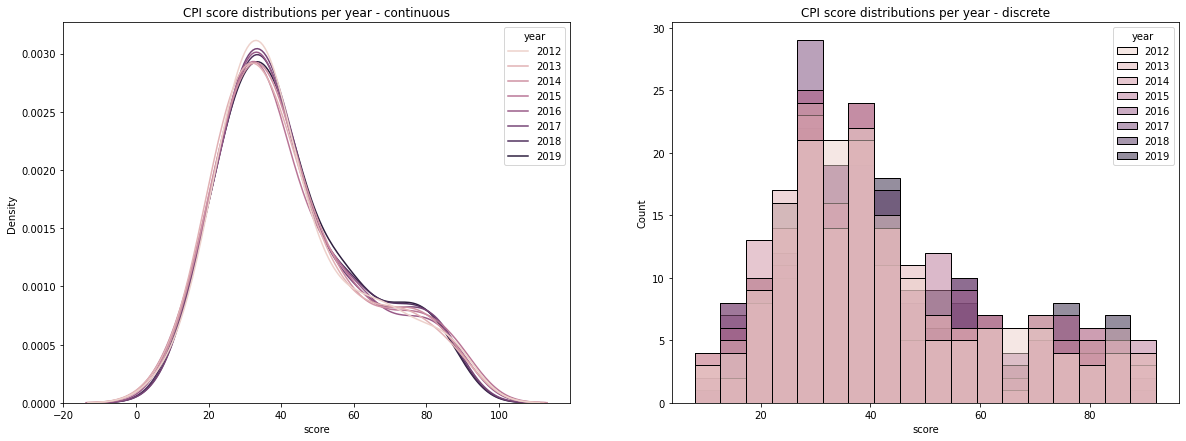

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.set_title('CPI score distributions per year - continuous')
ax2.set_title('CPI score distributions per year - discrete')

sns.kdeplot(data=df, x='score', hue='year', ax=ax1)
sns.histplot(data=df, x='score', hue='year', ax=ax2);

The strip plot of CPI scores per region shows that the CPI scores were generally high in the Western Europe/European Union (WE/EU) throughout the 2012-2019 period. Data for the Asia Pacific (AP) region spans almost the whole range of CPI values &ndash; a portion of the scores is comparable to the WE/EU ones, but there is also a significant number of countries with scores under 40. Most of the Sub-Saharan Africa (SSA) and Eastern Europe & Central Asia (ECA) scores are under 50.

It is interesting to note that scores for each year are equally scattered around each strip (in the sense that there is no grouping of scores from a certain year on a certain portion of the strip, instead they are all intertwined), most likely owing to the fact that their distributions are very similar.

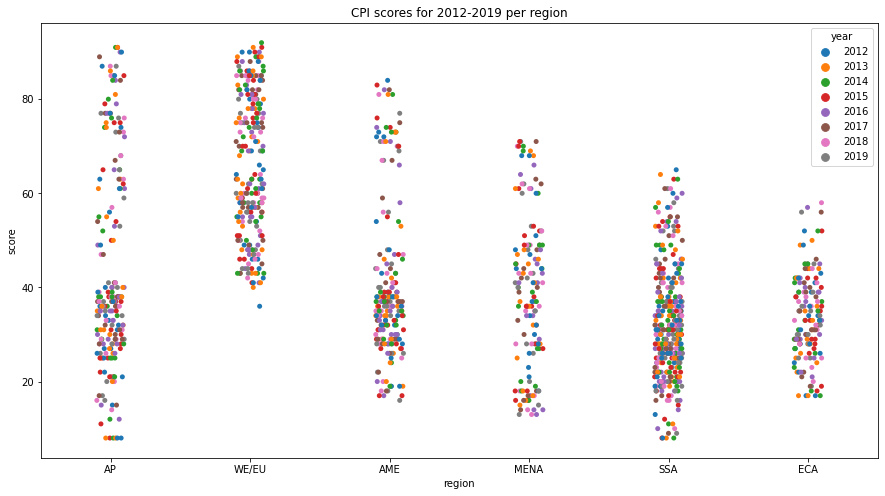

In [31]:
plt.figure(figsize=(15, 8))
plt.title('CPI scores for 2012-2019 per region')

sns.stripplot(data=df, x='region', y='score', hue='year');

The correlation matrix below points to several interesting characteristics of our data set:
* some of the WGI measures (`government effectiveness`, `regulatory quality`, `rule of law`) are highly positively correlated with each other, but also with IEF measures (`government integrity` and `property right`)
* some HDR indices are also strongly correlated with one another (e.g. `income index`-`education index`-`gender inequality index (gii)`-`coefficient of human inequality`)
* indicators such as `employment to population ratio`, `share of seats in parliament (% held by women)`, `government spending`, `labor freedom` have only low to moderate correlations with other measures

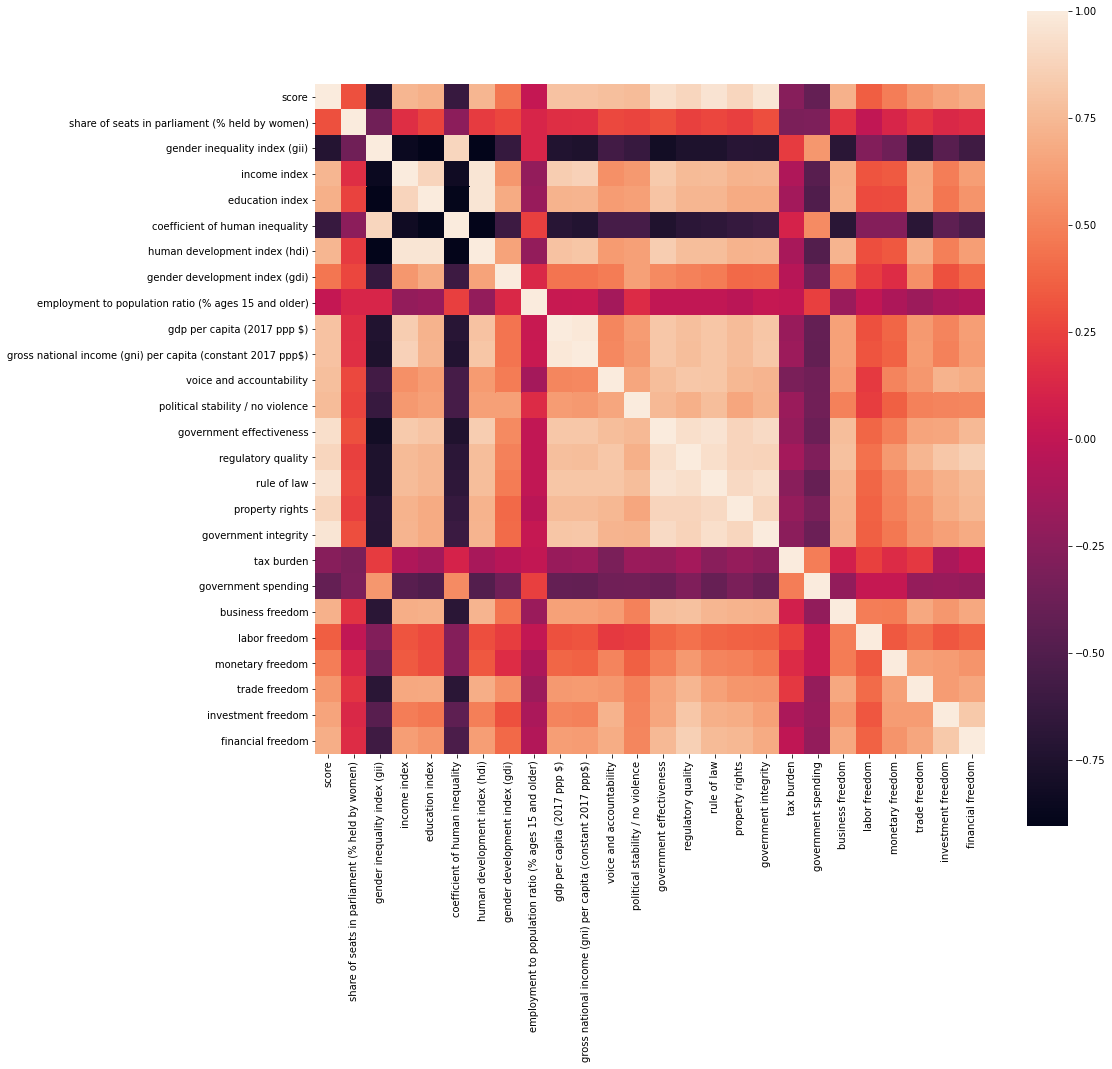

In [32]:
plt.figure(figsize=(15, 15))

corrs = df.drop('year', axis=1).corr()
sns.heatmap(corrs, square=True);

To be able to see the relationships more clearly, correlations with the target variable were plotted on a separate bar plot. Several measures have very high positive relationships with the CPI score, of which `government integrity` and `rule of law` stick out with coefficients of almost 1.0. On the negative side, `gender inequality index (gii)` also has a pretty high correlation with CPI (around -0.75).

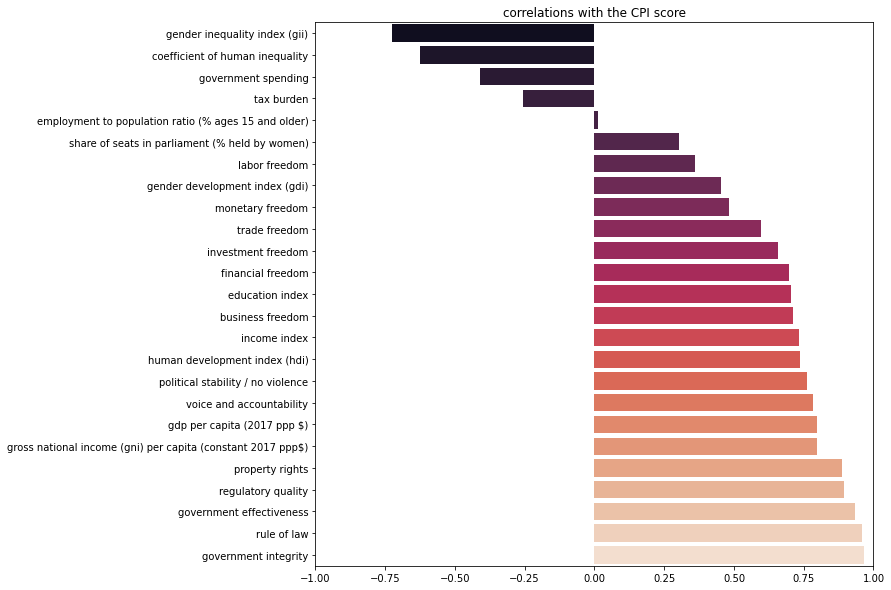

In [33]:
score_corrs = df.drop(columns=['year', 'score']).corrwith(df['score'])
score_corrs.sort_values(inplace=True)

plt.figure(figsize=(10, 10))
plt.title('correlations with the CPI score')
plt.xlim([-1.0, 1.0])

sns.barplot(x=score_corrs.values, y=score_corrs.index,
            palette=sns.color_palette('rocket', n_colors=score_corrs.size));

Three scatter plots are shown as examples of a clear linear trend between a variable and the target (left), no noticeable trend between a variable and the target (center), and a slight linear trend between a variable and the target (right):

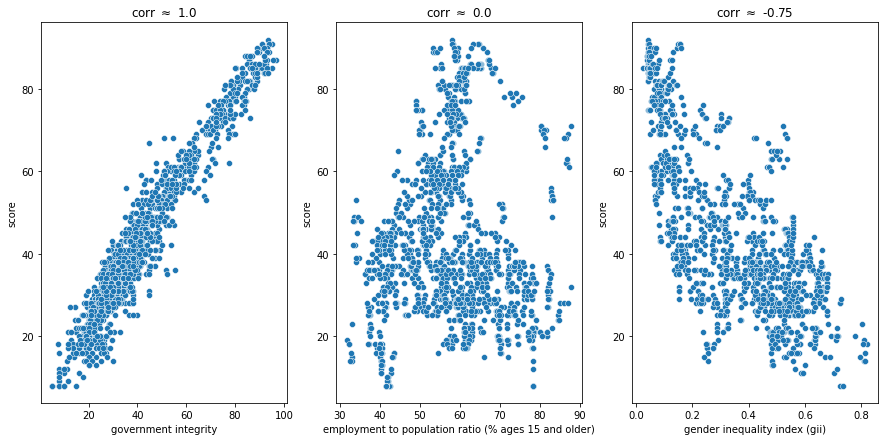

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

ax1.set_title(r'corr $\approx$ 1.0')
ax2.set_title(r'corr $\approx$ 0.0')
ax3.set_title(r'corr $\approx$ -0.75')

sns.scatterplot(x=df['government integrity'], y=df['score'], ax=ax1)
sns.scatterplot(x=df['employment to population ratio (% ages 15 and older)'], y=df['score'], ax=ax2)
sns.scatterplot(x=df['gender inequality index (gii)'], y=df['score'], ax=ax3);

## Handling missing values

If we examine the counts of not-`NaN` values in each column per year, most of the data seems to be available.

In [35]:
df.groupby('year').count()

,country,iso3,region,score,share of seats in parliament (% held by women),gender inequality index (gii),income index,education index,coefficient of human inequality,human development index (hdi),gender development index (gdi),employment to population ratio (% ages 15 and older),gdp per capita (2017 ppp $),gross national income (gni) per capita (constant 2017 ppp$),voice and accountability,political stability / no violence,government effectiveness,regulatory quality,rule of law,property rights,government integrity,tax burden,government spending,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,166,166,166,166,161,147,162,162,130,162,155,164,156,162,163,163,163,163,163,161,161,161,161,161,161,161,161,161,161
2013,166,166,166,166,157,142,162,162,138,162,155,164,157,162,163,163,163,163,163,162,166,161,162,164,164,163,161,164,161
2014,166,166,166,166,160,143,162,162,142,162,156,164,157,162,163,163,163,163,163,162,166,164,164,165,165,164,160,164,161
2015,166,166,166,166,161,149,162,162,142,162,156,164,157,162,163,163,163,163,163,162,166,162,164,165,165,164,161,164,160
2016,166,166,166,166,162,152,162,162,142,162,156,164,157,162,163,163,163,163,163,162,166,162,163,165,165,164,161,163,161
2017,166,166,166,166,162,150,162,162,143,162,157,164,157,162,163,163,163,163,163,166,166,163,164,166,166,164,163,161,161
2018,166,166,166,166,161,150,162,162,143,162,157,164,157,162,163,163,163,163,163,166,166,162,164,165,165,165,163,164,161
2019,166,166,166,166,163,152,162,162,143,162,157,164,157,162,163,163,163,163,163,166,166,161,164,166,165,165,163,164,161


The missing values will be imputed using _scikit-learn_'s `KNNImputer` based on the k-Nearest Neighbors algorithm. Each sample’s missing values are imputed using the mean value from `n_neighbors` nearest neighbors found in the training set.

This method was chosen as it takes into account the similarities between samples and uses them to compute the replacement value, instead of just replacing everything with a single value (mean, median, or similar).

We'll use the default setting for `n_neighbors` &ndash; 5.

## Models and results

We split the data set into training and test sets using a 70-30 split.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['score', 'country', 'iso3', 'region', 'year']),
    df['score'],
    test_size=0.3,
    random_state=123
)

print('Number of training set oberservations: {}'.format(X_train.shape[0]))
print('Number of test set oberservations: {}'.format(X_test.shape[0]))

Number of training set oberservations: 929
Number of test set oberservations: 399


In [37]:
def plot_results(y_train, y_pred_train, y_test, y_pred_test):
    """ 
    Create scatter plot of actual vs predicted data.
    
    Parameters
    --------
    y_train: observed training set data
    y_pred_train: predicted training set data
    y_test: observed test set data
    y_pred_test: predicted test set data
    """
    fig, ax = plt.subplots()
    
    ax.plot(y_train, y_pred_train, 'ro', label='train')
    ax.plot(y_test, y_pred_test, 'bo', label='test')
    
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    
    plt.legend(loc='upper left')
    ax.set_xlabel('actual CPI score')
    ax.set_ylabel('predicted CPI score')
    ax.set_title('actual vs predicted CPI score');

Five regression models were trained on `X_train` using 5-fold `GridSearchCV` to find optimal hyperparameters (if applicable). The best obtained model was then tested on the test set.

Two standard performance metrics were used for evaluation &ndash; R2 and Mean-Squared Error (MSE). The actual and predicted CPI scores for the training and test sets were plotted using the `plot_results` function.

Where needed, scaling (`MinMaxScaler`) was applied before training the model.

### Baseline

Inspired by the strong correlation between `government integrity` and `score`, we chose a very simple one-variable linear model as the baseline with which we can compare other models:

In [38]:
X_train_base = X_train['government integrity'].values.reshape(-1, 1)
X_test_base = X_test['government integrity'].values.reshape(-1, 1)

In [39]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

gscv = GridSearchCV(estimator=pipeline, param_grid={}, scoring='r2',
                    n_jobs=-1, verbose=2).fit(X_train_base, y_train)
dump(gscv, 'results/baseline.gscv')

print(f'CV mean test R2: {gscv.cv_results_["mean_test_score"][0]:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CV mean test R2: 0.9252


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


The baseline model achieves a high R2 score and a test set MSE of around 26. The scatter plot of actual and predicted CPI scores closely resembles the 45-degree line, also indicating a good fit.

Test MSE: 26.1042
Test R2: 0.9319


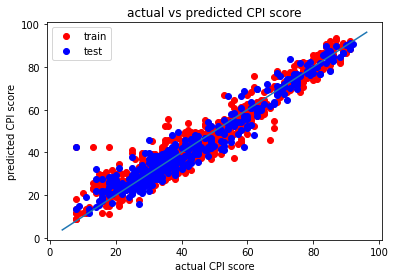

In [40]:
y_pred_train = gscv.predict(X_train_base)
y_pred_test = gscv.predict(X_test_base)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

### 1) Linear regression

A linear regression model using all of the 25 variables achieves a better performance than the baseline model, especially considering the test set MSE which now dropped to around 16.

In [41]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

gscv = GridSearchCV(estimator=pipeline, param_grid={},
                    scoring='r2', n_jobs=-1, verbose=2).fit(X_train, y_train)
dump(gscv, 'results/linreg.gscv')

print(f'CV Mean Test R2: {gscv.cv_results_["mean_test_score"][0]:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


CV Mean Test R2: 0.9584


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Test MSE: 15.9717
Test R2: 0.9583


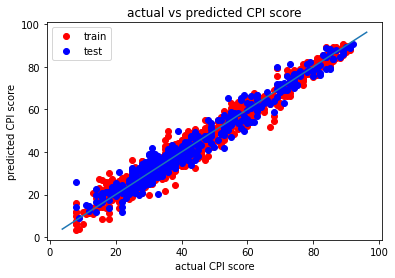

In [42]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

#### Feature importance

A benefit of using linear regression is being able to examine which features are important for the model based on the estimated coefficients. The plot below is generally consistent with the relationships seen when plotting correlation coefficients. `government integrity` has by far the largest coefficient.

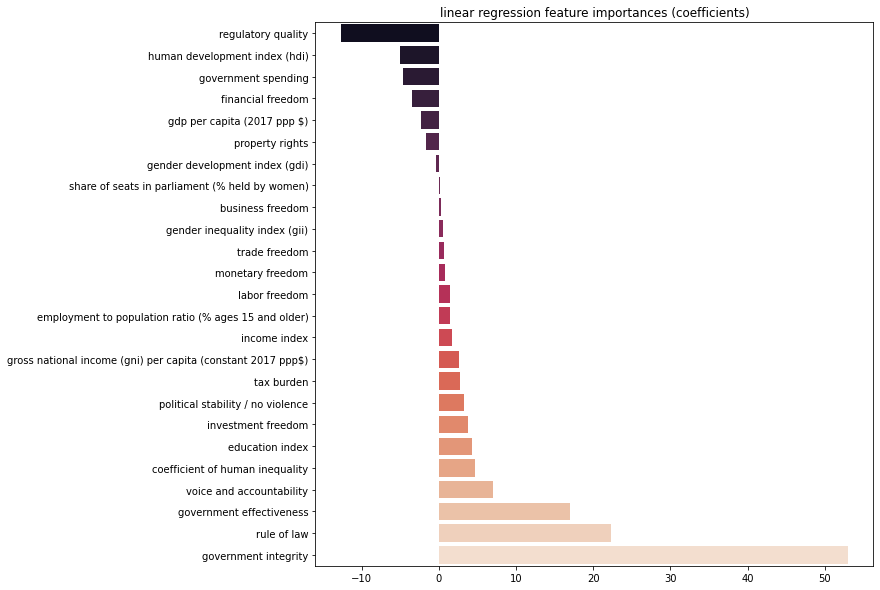

In [43]:
importances = gscv.best_estimator_['model'].coef_
features = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('linear regression feature importances (coefficients)')

sns.barplot(x=importances[sorted_idx], y=features[sorted_idx], 
            palette=sns.color_palette('rocket', n_colors=features.size));

### 2) ElasticNet

Several parameter combinations were examined for the ElasticNet model, of which `alpha=0.1, l1_ratio=1.0` seems to be the best one. The `l1_ratio=1.0` parameter signifies that we are using the L1 penalty for model coefficients, which could result in feature elimination.

In [44]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
    ('model', ElasticNet())
])

grid = {
    'model__alpha': np.linspace(0.1, 1.0, 10),
    'model__l1_ratio': np.linspace(0.0, 1.0, 9)
}

gscv = GridSearchCV(pipeline, param_grid=grid, scoring='r2',
                    n_jobs=-1, verbose=2).fit(X_train, y_train)
dump(gscv, 'results/elasticnet.gscv')

print(f'Best CV mean test R2: {gscv.cv_results_["mean_test_score"].max():.4f}')
print(f'Best parameters: {gscv.best_params_}')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s


Best CV mean test R2: 0.9562
Best parameters: {'model__alpha': 0.1, 'model__l1_ratio': 1.0}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    4.7s finished


This model has a very similar performance to linear regression.

Test MSE: 16.4886
Test R2: 0.9570


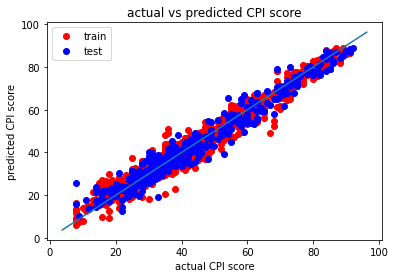

In [45]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

#### Feature importance

The plot of ElasticNet feature importances is particularly interesting since the model uses the L1 penalty. This resulted in some variables' coefficients being set to zero, which in effect performed feature selection. `government integrity` is once again the most important feature.

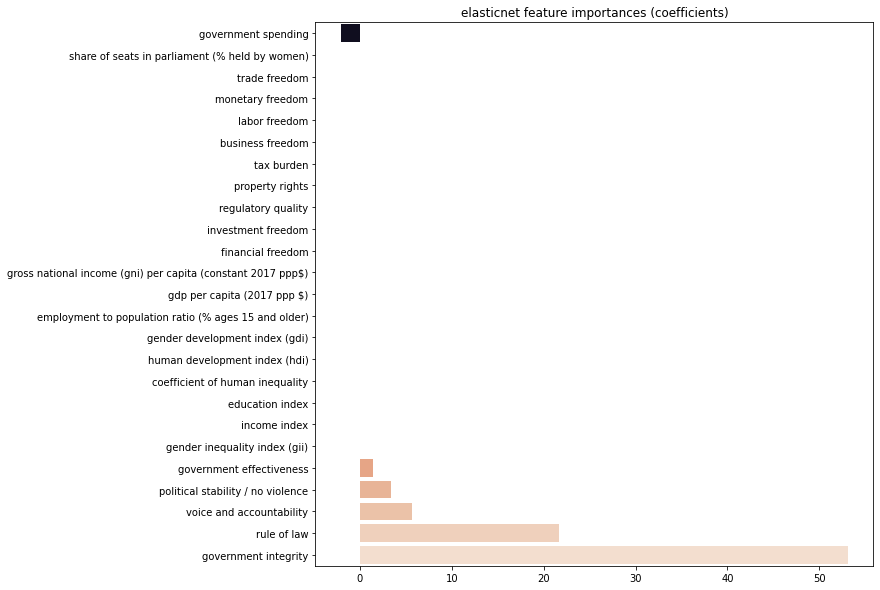

In [46]:
importances = gscv.best_estimator_['model'].coef_
features = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('elasticnet feature importances (coefficients)')

sns.barplot(x=importances[sorted_idx], y=features[sorted_idx], 
            palette=sns.color_palette('rocket', n_colors=features.size));

### 3) Random Forest

The random forest model performs better than the previous models on both R2 and MSE.

In [47]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('model', RandomForestRegressor())
])

grid = {
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 3, 4],
    'model__min_samples_leaf': [2, 3, 4]
}

gscv = GridSearchCV(pipeline, param_grid=grid, scoring='r2',
                    n_jobs=-1, verbose=2).fit(X_train, y_train)
dump(gscv, 'results/rf.gscv')

print(f'Best CV mean test R2: {gscv.cv_results_["mean_test_score"].max():.4f}')
print(f'Best parameters: {gscv.best_params_}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   16.0s finished


Best CV mean test R2: 0.9729
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}


Test MSE: 9.8694
Test R2: 0.9742


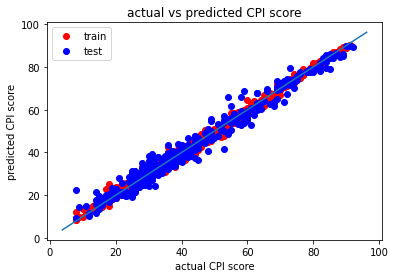

In [48]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

#### Feature importance

The feature importances plot for random forest also indicates that some variables aren't used in the model. Interestingly enough, `government integrity` is not the most important feature here, being replaced by `rule of law`.

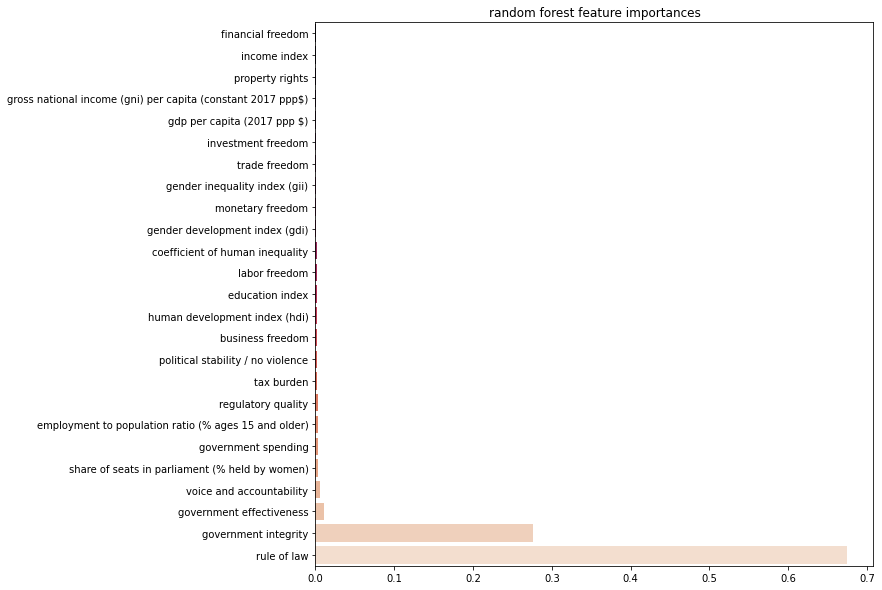

In [49]:
importances = gscv.best_estimator_['model'].feature_importances_
features = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('random forest feature importances')

sns.barplot(x=importances[sorted_idx], y=features[sorted_idx], 
            palette=sns.color_palette('rocket', n_colors=features.size));

### 4) SVM

The SVM model managed to achieve a test set R2 of around 0.98 and reduced the MSE below 10.

In [50]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

grid = {
    'model__kernel': ['linear', 'rbf'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

gscv = GridSearchCV(pipeline, param_grid=grid, scoring='r2',
                    n_jobs=-1, verbose=2).fit(X_train, y_train)
dump(gscv, 'results/svm.gscv')

print(f'Best CV mean test R2: {gscv.cv_results_["mean_test_score"].max():.4f}')
print(f'Best parameters: {gscv.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Best CV mean test R2: 0.9776
Best parameters: {'model__C': 100, 'model__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished


Test MSE: 7.6442
Test R2: 0.9800


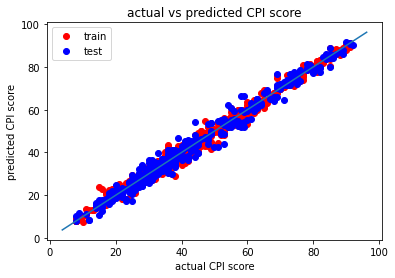

In [51]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

### 5) MLP

Finally, several single-hidden-layer MLP models were considered, the best of which had a hidden layer of 30 neurons. Its performance does not surpass random forest or SVM, but is comparable to logistic regression and ElasticNet.

In [52]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', MinMaxScaler()),
    ('model', MLPRegressor(max_iter=1000))
])

grid = {
    'model__hidden_layer_sizes': [(30,), (40,), (50,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam']
}

gscv = GridSearchCV(pipeline, param_grid=grid, scoring='r2',
                    n_jobs=-1, verbose=2).fit(X_train, y_train)
dump(gscv, 'results/mlp.gscv')

print(f'Best CV mean test R2: {gscv.cv_results_["mean_test_score"].max():.4f}')
print(f'Best parameters: {gscv.best_params_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   41.1s finished


Best CV mean test R2: 0.9630
Best parameters: {'model__activation': 'tanh', 'model__hidden_layer_sizes': (30,), 'model__solver': 'sgd'}


Test MSE: 14.7483
Test R2: 0.9615


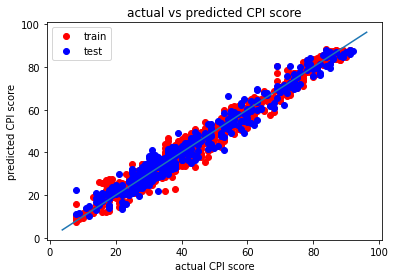

In [53]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
print('Test MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred_test)))
print('Test R2: {:.4f}'.format(r2_score(y_test, y_pred_test)))
plot_results(y_train, y_pred_train, y_test, y_pred_test)

## Conclusion

We considered several country indicators and indexes obtained from different sources as predictor variables for the CPI score. Missing variables where imputed using the k-Nearest Neighbors algorithm, and _min-max_ scaling was applied when needed by the model.

Five models of different characteristics were considered and compared to a baseline one-variable linear model. The best performance was achieved by the SVM model (MSE around 7, R2 around 0.98), followed closely behind by random forest. The linear regression, ElasticNet, and MLP models had a somewhat worse performance, but still managed to surpass the baseline.

An analysis of feature importances for the linear regression, ElasticNet, and random forest models clearly indicated that variables such as `government integrity` and `rule of law` can be used to predict the CPI score. The data set's correlation matrix previously indicated that these variables have a high positive correlation with the score.

## Authors

* Bruna Dujmovic, 12005502